In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"US/Eastern\"")

In [ ]:
hex_project_id = _hex_json.loads("\"41d01d76-f845-4e7c-96e2-311dfdc0e11c\"")

In [ ]:
hex_project_name = _hex_json.loads("\"DTSC_Studio3_Proj2\"")

In [ ]:
hex_status = _hex_json.loads("\"\"")

In [ ]:
hex_categories = _hex_json.loads("[]")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [ ]:
!pip install pybats

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import geopandas
import scipy.stats as st
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf


START OF ADDING IN THE FILES 

this part of the code is just me adding in the files and merging them accordingly



Predicting Crime type evolving over time grab other data inflation, population by census track by year



In [ ]:
# files = ['2013_Incident.csv', '2014_Incident.csv', '2015_Incident.csv','2016_Incident.csv' ]
# df = pd.DataFrame()
# for file in files:
#     data = pd.read_csv(file)
#     incidents_df = pd.concat([df, data], axis=0)

In [ ]:
files = ['2012_Incident.csv','2013_Incident.csv', '2014_Incident.csv', '2015_Incident.csv','2016_Incident.csv' ]
li = []
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
incidents_df = pd.concat(li, axis=0, ignore_index=True)


/tmp/ipykernel_12/2640899828.py:8: DtypeWarning:

Columns (17,28,29) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
incidents_df['Reported_Date']

0          6/16/12
1          6/16/12
2          6/16/12
3          6/16/12
4          6/16/12
            ...   
501249    12/31/16
501250    12/31/16
501251    12/31/16
501252    12/31/16
501253    12/31/16
Name: Reported_Date, Length: 501254, dtype: object

In [ ]:
# incident = incidents_df
# incident.to_csv("incident.csv")

In [ ]:
incident = pd.read_csv("geo_data_allyears.csv")
incident["Year"] = pd.to_datetime(incident["Reported_Date"]).dt.year
incident["Month"] = pd.to_datetime(incident["Reported_Date"]).dt.month

# incident['Year'].unique()
incident['Reported_Date']

0          6/16/2012 0:00:00
1          6/16/2012 0:00:00
2          6/16/2012 0:00:00
3          6/16/2012 0:00:00
4          6/16/2012 0:00:00
                 ...        
463952    12/31/2016 0:00:00
463953    12/31/2016 0:00:00
463954    12/31/2016 0:00:00
463955    12/31/2016 0:00:00
463956    12/31/2016 0:00:00
Name: Reported_Date, Length: 463957, dtype: object

In [ ]:
incident['NIBRS_Hi_Class'].value_counts()

All Other Thefts                                                                                        48543
Theft From Motor Vehicle                                                                                42854
Simple Assault                                                                                          42056
Burglary/B&E                                                                                            34852
Damage/Vandalism Of Property                                                                            33084
                                                                                                        ...  
Betting/Wagering                                                                                           11
Welfare Fraud                                                                                               7
Negligent Manslaughter                                                                                      3
Bribery   

Turning the data into quarters then organizing and grouping it correctly



In [ ]:
quarter_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 4,
    11: 4,
    12: 4,
}


incident["Quarter"] = incident["Month"].map(quarter_dict)
incident = incident.drop('Month',axis=1)
incident["NIBRS_Hi_Class"] = incident["NIBRS_Hi_Class"].str.strip()
crimes = ["All Other Thefts", "Simple Assault", "Theft From Motor Vehicle"]
incident = incident[incident["NIBRS_Hi_Class"].isin(crimes)]

incident_grouped = (
    incident.groupby(["geoid10", "Year", "Quarter", "NIBRS_Hi_Class"])
    .size()
    .reset_index(name="counts")
)
incident_data = pd.merge(
    incident,
    incident_grouped,
    on=["geoid10", "Year", "NIBRS_Hi_Class", "Quarter"],
    how="left",
)
incident_data = incident_data.drop_duplicates()
incident_data = incident_data.pivot_table(
    index=["geoid10", "Year", "Quarter"],
    columns="NIBRS_Hi_Class",
    values="counts",
    fill_value=0,
)
incident_data.reset_index(inplace=True)
incident_data.sort_values(by=["geoid10", "Year", "Quarter"], inplace=True)

incident_data = incident_data.drop_duplicates(["geoid10", "Year", "Quarter"])
incident_data = (
    incident_data.set_index(["geoid10", "Year", "Quarter"])
    .unstack(fill_value=0)
    .stack()
    .reset_index()
)
incident_data = incident_data[incident_data["geoid10"] != "37119000600"]
incident_data[["All Other Thefts", "Simple Assault", "Theft From Motor Vehicle"]] = incident_data.groupby(["geoid10", "Year", "Quarter"])[["All Other Thefts", "Simple Assault", "Theft From Motor Vehicle"]].transform('sum')
incident = incident_data


Bringing in the average high and total precipitation data from Extreme Weather Watch.  https://www.extremeweatherwatch.com/cities/charlotte/most-yearly-precipitation 

Method I use to standardize all of my predictors



In [ ]:
def zstandard(data):
    data = (data - data.mean()) / data.std()
    return data

In [ ]:
weather = pd.read_excel("Summary_Weather.xlsx")
df_weather = pd.DataFrame(weather)
df_weather['Quarter'] = df_weather['Month'].map(quarter_dict)
df_weather = df_weather.groupby(["Year ", "Quarter"]).mean()
df_weather['Average High'] = zstandard(df_weather['Average High'])
df_weather['Total Precipitation'] = zstandard(df_weather['Total Precipitation'])
df_weather

Month 
 Average High 
 Total Precipitation 
 
 
 Year 
 Quarter 
 
 
 
 
 
 
 
 2012 
 1 
 2.0 
 -0.818604 
 -0.762552 
 
 
 2 
 5.0 
 0.645022 
 -0.483927 
 
 
 3 
 8.0 
 1.192063 
 0.322618 
 
 
 4 
 11.0 
 -0.689329 
 -1.195154 
 
 
 2013 
 1 
 2.0 
 -1.344484 
 0.146645 
 
 
 2 
 5.0 
 0.451482 
 1.046065 
 
 
 3 
 8.0 
 0.964403 
 0.422825 
 
 
 4 
 11.0 
 -0.722765 
 0.158865 
 
 
 2014 
 1 
 2.0 
 -1.414879 
 0.197970 
 
 
 2 
 5.0 
 0.667275 
 0.892088 
 
 
 3 
 8.0 
 0.954475 
 0.371500 
 
 
 4 
 11.0 
 -0.709271 
 -0.703894 
 
 
 2015 
 1 
 2.0 
 -1.397762 
 -0.630572 
 
 
 2 
 5.0 
 0.811488 
 -0.300621 
 
 
 3 
 8.0 
 1.285010 
 -0.681898 
 
 
 4 
 11.0 
 -0.425409 
 3.353274 
 
 
 2016 
 1 
 2.0 
 -1.133209 
 -0.723447 
 
 
 2 
 5.0 
 0.688329 
 -0.026885 
 
 
 3 
 8.0 
 1.496551 
 -0.420381 
 
 
 4 
 11.0 
 -0.500383 
 -0.982519

In [ ]:
enrollment = pd.read_csv("Enrollment_Data.csv")

enrollment = enrollment[
    [
        "geoid10",
        "Percent Enrolled K_12",
        "Year",
    ]
]
enrollment["geoid10"] = enrollment["geoid10"].str[9:]
enrollment[enrollment["Percent Enrolled K_12"] == "-"] = np.nan
enrollment["Percent Enrolled K_12"] = enrollment["Percent Enrolled K_12"].astype(float)
enrollment["Percent Enrolled K_12"] = enrollment["Percent Enrolled K_12"] / 100
enrollment

,geoid10,Percent Enrolled K_12,Year
0,37119,0.867,2011.0
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,37119000500,0.825,2011.0
...,...,...,...
1633,37119006406,0.959,2016.0
1634,37119006407,0.946,2016.0
1635,NaN,NaN,NaN
1636,NaN,NaN,NaN


In [ ]:
data = pd.read_csv("Poverty_2012-2016.csv")
data = data[
    [
        "geoid10",
        "Total!!Estimate!!Population for whom poverty status is determined",
        "Year",
    ]
]
data['geoid10'] = data['geoid10'].str[9:]
data['Total!!Estimate!!Population for whom poverty status is determined'] = zstandard(data['Total!!Estimate!!Population for whom poverty status is determined'])
data

/tmp/ipykernel_12/1339336130.py:5: DtypeWarning:

Columns (202,203,204,205,214,215,216,217,226,227,228,229,238,239,240,241,250,251,252,253,262,263,264,265,274,275,276,277,286,287,288,289,298,299,300,301,310,311,312,313,322,323,324,325,334,335,336,337,346,347,348,349,358,359,360,361,370,371,372,373,382,383,384,385,394,395,396,397,406,407,408,409,418,419,420,421,430,431,432,433,442,443,444,445,450,451,452,453,454,455,456,457,462,463,464,465,466,467,468,469,474,475,476,477,478,479,480,481,486,487,488,489,490,491,492,493,498,499,500,501,502,503,504,505,510,511,512,513,514,515,516,517,522,523,524,525,526,527,528,529,534,535,536,537,538,539,540,541,550,551,552,553,562,563,564,565,574,575,576,577,586,587,588,589,598,599,600,601,610,611,612,613,622,623,624,625,634,635,636,637,646,647,648,649,658,659,660,661,670,671,672,673,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,706,707,708,709,718,719,720,721,730,731,732,733) have mixed types. Specify dtype option on import or set low_

,geoid10,Total!!Estimate!!Population for whom poverty status is determined,Year
0,37119000100,0.174986,2016
1,37119000300,-2.031620,2016
2,37119000400,-0.856138,2016
3,37119000500,0.139633,2016
4,37119000600,-0.774827,2016
...,...,...,...
1160,37119006406,1.271513,2012
1161,37119006407,-0.498486,2012
1162,37119980100,-2.411663,2012
1163,37119980200,-2.411663,2012


In [ ]:
incident["geoid10"] = incident["geoid10"].astype(str).str[:-3]
incident = pd.merge(incident, enrollment, on=["geoid10", "Year"])

In [ ]:
incident_grouped = (
    incident.groupby(["geoid10", "Year", "Quarter"])
    .agg(
        {
            "All Other Thefts": "sum",
            "Simple Assault": "sum",
            "Theft From Motor Vehicle": "sum",
        }
    )
    .reset_index()
)
incident = pd.merge(
    incident, incident_grouped, on=["geoid10", "Year", "Quarter"], how="left"
)


In [ ]:
incident = incident.drop_duplicates(["geoid10", "Year", "Quarter", "All Other Thefts_y", "Simple Assault_y", "Theft From Motor Vehicle_y"])

In [ ]:
# incident = incident.drop(
#     [
#         "shape_leng",
#         "intptlon10",
#         "intptlat10",
#         "awater10",
#         "aland10",
#         "funcstat10",
#         "mtfcc10",
#         "namelsad10",
#         "blkgrpce10",
#         "Y_Coordinate",
#         "X_Coordinate",
#         "Street_Name",
#         "Complaint_No",
#         "TARGET_FID",
#         "Join_Count",
#         "OID_",
#     ],
#     axis=1,
# )
# incident["NIBRS_Hi_Class"] = incident["NIBRS_Hi_Class"].str.strip()
# crimes = ["Aggravated Assault", "Robbery", "Weapon Law Violations", "Murder"]
# incident = incident[incident["NIBRS_Hi_Class"].isin(crimes)]

In [ ]:
# incident_grouped = (
#     incident.groupby(["geoid10", "Month", "Year", "NIBRS_Hi_Class"])
#     .size()
#     .reset_index(name="counts")
# )
# incident_data = pd.merge(
#     incident,
#     incident_grouped,
#     on=["geoid10", "Year", "NIBRS_Hi_Class", "Month"],
#     how="left",
# )
# incident_data = incident_data.drop_duplicates()
# incident_data = incident_data.pivot_table(
#     index=["geoid10", "Year", "Month"],
#     columns="NIBRS_Hi_Class",
#     values="counts",
#     fill_value=0,
# )
# incident_data.reset_index(inplace=True)
# incident_data.sort_values(by=["geoid10", "Year", "Month"], inplace=True)


In [ ]:
# incident = incident_data
# incident

In [ ]:
incident = pd.merge(
    incident,
    df_weather,
    left_on=["Year", "Quarter"],
    right_on=["Year ", "Quarter"],
    how="left",
)

Bringing in the gas data from US Energy Information Administration.  https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=ema_epm0_pwg_snc_dpg&f=a 

In [ ]:
gas = pd.read_csv("Gas_Prices - Sheet1 (2).csv")
df_gas = pd.DataFrame(gas)
df_gas['Quarter'] = df_gas['Month'].map(quarter_dict)
df_gas = df_gas.groupby(["Year", "Quarter"]).mean()
df_gas['Wholesale Price of Gas'] = zstandard(df_gas['Wholesale Price of Gas'])
df_gas

Month 
 Wholesale Price of Gas 
 
 
 Year 
 Quarter 
 
 
 
 
 
 
 2011 
 1 
 2.0 
 0.508024 
 
 
 2 
 5.0 
 1.108430 
 
 
 3 
 8.0 
 0.915088 
 
 
 4 
 11.0 
 0.556098 
 
 
 2012 
 1 
 2.0 
 1.001830 
 
 
 2 
 5.0 
 0.787064 
 
 
 3 
 8.0 
 0.922926 
 
 
 4 
 11.0 
 0.558188 
 
 
 2013 
 1 
 2.0 
 0.849769 
 
 
 2 
 5.0 
 0.627165 
 
 
 3 
 8.0 
 0.657995 
 
 
 4 
 11.0 
 0.397244 
 
 
 2014 
 1 
 2.0 
 0.526836 
 
 
 2 
 5.0 
 0.916655 
 
 
 3 
 8.0 
 0.535196 
 
 
 4 
 11.0 
 -0.528186 
 
 
 2015 
 1 
 2.0 
 -1.217947 
 
 
 2 
 5.0 
 -0.676589 
 
 
 3 
 8.0 
 -1.079995 
 
 
 4 
 11.0 
 -1.500644 
 
 
 2016 
 1 
 2.0 
 -1.862247 
 
 
 2 
 5.0 
 -1.266544 
 
 
 3 
 8.0 
 -1.455705 
 
 
 4 
 11.0 
 -1.280652

In [ ]:
incident = pd.merge(incident, df_gas, on=["Year", "Quarter"], how='left')
incident

,geoid10,Year,Quarter,All Other Thefts_x,Simple Assault_x,Theft From Motor Vehicle_x,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Average High,Total Precipitation,Month_y,Wholesale Price of Gas
0,37119000100,2012,1,9,6,8,1.000,95,79,65,2.0,-0.818604,-0.762552,2.0,1.001830
1,37119000100,2012,2,10,4,7,1.000,126,54,73,5.0,0.645022,-0.483927,5.0,0.787064
2,37119000100,2012,3,24,12,22,1.000,196,104,152,8.0,1.192063,0.322618,8.0,0.922926
3,37119000100,2012,4,30,6,12,1.000,228,98,98,11.0,-0.689329,-1.195154,11.0,0.558188
4,37119000100,2013,1,9,4,9,1.000,107,61,44,2.0,-1.344484,0.146645,2.0,0.849769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,37119006407,2012,4,0,0,0,0.916,0,0,0,11.0,-0.689329,-1.195154,11.0,0.558188
4264,37119006407,2013,1,0,0,0,0.926,0,0,0,2.0,-1.344484,0.146645,2.0,0.849769
4265,37119006407,2013,2,0,0,0,0.926,0,0,0,5.0,0.451482,1.046065,5.0,0.627165
4266,37119006407,2013,3,0,1,0,0.926,1,1,0,8.0,0.964403,0.422825,8.0,0.657995


In [ ]:
incident_data = incident

In [ ]:

incident_data

,geoid10,Year,Quarter,All Other Thefts_x,Simple Assault_x,Theft From Motor Vehicle_x,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Average High,Total Precipitation,Month_y,Wholesale Price of Gas
0,37119000100,2012,1,9,6,8,1.000,95,79,65,2.0,-0.818604,-0.762552,2.0,1.001830
1,37119000100,2012,2,10,4,7,1.000,126,54,73,5.0,0.645022,-0.483927,5.0,0.787064
2,37119000100,2012,3,24,12,22,1.000,196,104,152,8.0,1.192063,0.322618,8.0,0.922926
3,37119000100,2012,4,30,6,12,1.000,228,98,98,11.0,-0.689329,-1.195154,11.0,0.558188
4,37119000100,2013,1,9,4,9,1.000,107,61,44,2.0,-1.344484,0.146645,2.0,0.849769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,37119006407,2012,4,0,0,0,0.916,0,0,0,11.0,-0.689329,-1.195154,11.0,0.558188
4264,37119006407,2013,1,0,0,0,0.926,0,0,0,2.0,-1.344484,0.146645,2.0,0.849769
4265,37119006407,2013,2,0,0,0,0.926,0,0,0,5.0,0.451482,1.046065,5.0,0.627165
4266,37119006407,2013,3,0,1,0,0.926,1,1,0,8.0,0.964403,0.422825,8.0,0.657995


In [ ]:
data["geoid10"] = data["geoid10"].astype(str)
incident_data = pd.merge(
    incident_data, data, on=["Year", "geoid10"], 
)
incident_data

,geoid10,Year,Quarter,All Other Thefts_x,Simple Assault_x,Theft From Motor Vehicle_x,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Average High,Total Precipitation,Month_y,Wholesale Price of Gas,Total!!Estimate!!Population for whom poverty status is determined
0,37119000100,2012,1,9,6,8,1.000,95,79,65,2.0,-0.818604,-0.762552,2.0,1.001830,-0.404801
1,37119000100,2012,2,10,4,7,1.000,126,54,73,5.0,0.645022,-0.483927,5.0,0.787064,-0.404801
2,37119000100,2012,3,24,12,22,1.000,196,104,152,8.0,1.192063,0.322618,8.0,0.922926,-0.404801
3,37119000100,2012,4,30,6,12,1.000,228,98,98,11.0,-0.689329,-1.195154,11.0,0.558188,-0.404801
4,37119000100,2013,1,9,4,9,1.000,107,61,44,2.0,-1.344484,0.146645,2.0,0.849769,-0.323489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,37119006407,2012,4,0,0,0,0.916,0,0,0,11.0,-0.689329,-1.195154,11.0,0.558188,-0.498486
4264,37119006407,2013,1,0,0,0,0.926,0,0,0,2.0,-1.344484,0.146645,2.0,0.849769,-0.336452
4265,37119006407,2013,2,0,0,0,0.926,0,0,0,5.0,0.451482,1.046065,5.0,0.627165,-0.336452
4266,37119006407,2013,3,0,1,0,0.926,1,1,0,8.0,0.964403,0.422825,8.0,0.657995,-0.336452


In [ ]:
incident_data

,geoid10,Year,Quarter,All Other Thefts_x,Simple Assault_x,Theft From Motor Vehicle_x,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Average High,Total Precipitation,Month_y,Wholesale Price of Gas,Total!!Estimate!!Population for whom poverty status is determined
0,37119000100,2012,1,9,6,8,1.000,95,79,65,2.0,-0.818604,-0.762552,2.0,1.001830,-0.404801
1,37119000100,2012,2,10,4,7,1.000,126,54,73,5.0,0.645022,-0.483927,5.0,0.787064,-0.404801
2,37119000100,2012,3,24,12,22,1.000,196,104,152,8.0,1.192063,0.322618,8.0,0.922926,-0.404801
3,37119000100,2012,4,30,6,12,1.000,228,98,98,11.0,-0.689329,-1.195154,11.0,0.558188,-0.404801
4,37119000100,2013,1,9,4,9,1.000,107,61,44,2.0,-1.344484,0.146645,2.0,0.849769,-0.323489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,37119006407,2012,4,0,0,0,0.916,0,0,0,11.0,-0.689329,-1.195154,11.0,0.558188,-0.498486
4264,37119006407,2013,1,0,0,0,0.926,0,0,0,2.0,-1.344484,0.146645,2.0,0.849769,-0.336452
4265,37119006407,2013,2,0,0,0,0.926,0,0,0,5.0,0.451482,1.046065,5.0,0.627165,-0.336452
4266,37119006407,2013,3,0,1,0,0.926,1,1,0,8.0,0.964403,0.422825,8.0,0.657995,-0.336452


Correlation Matrix of every variable



In [ ]:
corr_matrix = incident_data.corr(method='pearson')
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                                                            Year  \
Year                                                1.000000e+00   
Quarter                                            -1.211185e-15   
All Other Thefts_x                                 -1.147910e-01   
Simple Assault_x                                   -1.061871e-01   
Theft From Motor Vehicle_x                          1.337137e-02   
Percent Enrolled K_12                               2.572889e-02   
All Other Thefts_y                                 -9.067859e-02   
Simple Assault_y                                   -9.659278e-02   
Theft From Motor Vehicle_y                          1.505022e-02   
Month_x                                            -1.208503e-15   
Average High                                        5.051691e-02   
Total Precipitation                                -7.545771e-03   
Month_y                                            -1.208503e-15   
Wholesale Price of Gas      

<AxesSubplot:>

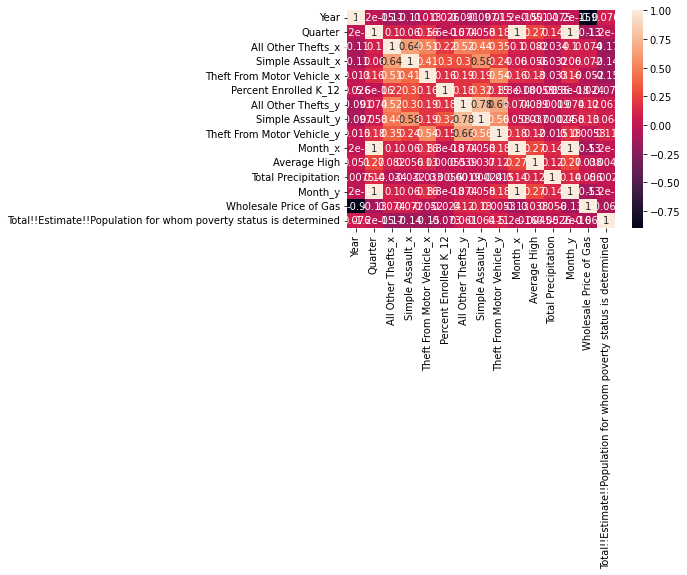

In [ ]:
sns.heatmap(corr_matrix, annot=True)

In [ ]:
incident_data

,geoid10,Year,Quarter,All Other Thefts_x,Simple Assault_x,Theft From Motor Vehicle_x,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Average High,Total Precipitation,Month_y,Wholesale Price of Gas,Total!!Estimate!!Population for whom poverty status is determined
0,37119000100,2012,1,9,6,8,1.000,95,79,65,2.0,-0.818604,-0.762552,2.0,1.001830,-0.404801
1,37119000100,2012,2,10,4,7,1.000,126,54,73,5.0,0.645022,-0.483927,5.0,0.787064,-0.404801
2,37119000100,2012,3,24,12,22,1.000,196,104,152,8.0,1.192063,0.322618,8.0,0.922926,-0.404801
3,37119000100,2012,4,30,6,12,1.000,228,98,98,11.0,-0.689329,-1.195154,11.0,0.558188,-0.404801
4,37119000100,2013,1,9,4,9,1.000,107,61,44,2.0,-1.344484,0.146645,2.0,0.849769,-0.323489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,37119006407,2012,4,0,0,0,0.916,0,0,0,11.0,-0.689329,-1.195154,11.0,0.558188,-0.498486
4264,37119006407,2013,1,0,0,0,0.926,0,0,0,2.0,-1.344484,0.146645,2.0,0.849769,-0.336452
4265,37119006407,2013,2,0,0,0,0.926,0,0,0,5.0,0.451482,1.046065,5.0,0.627165,-0.336452
4266,37119006407,2013,3,0,1,0,0.926,1,1,0,8.0,0.964403,0.422825,8.0,0.657995,-0.336452


Lineplot of each crime counts for each crime in  quarter in each year 



/tmp/ipykernel_12/3284689248.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



(array([15340., 15522., 15706., 15887., 16071., 16252., 16436., 16617.,
        16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

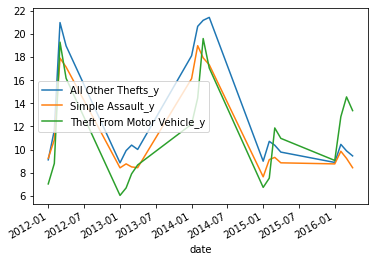

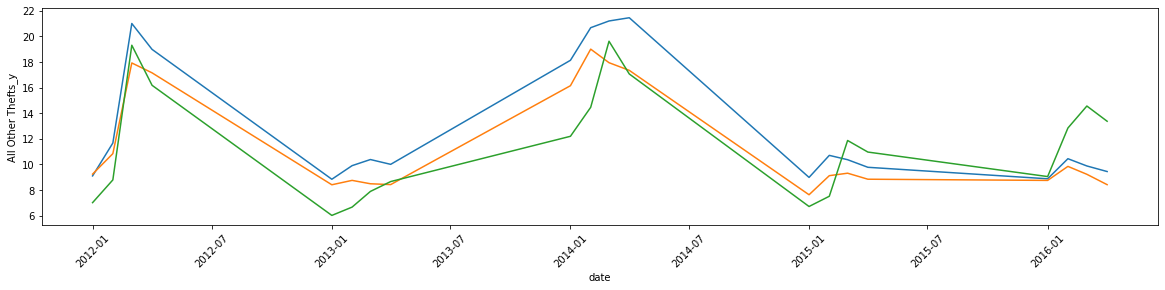

In [ ]:
scatter_data = incident_data.groupby(by=["Year", "Quarter"]).mean().reset_index()
scatter_data["date"] = pd.to_datetime(
    dict(year=scatter_data.Year, month=scatter_data.Quarter, day=1)
)
scatter_data = scatter_data[
    ["date", "All Other Thefts_y", "Simple Assault_y", "Theft From Motor Vehicle_y"]
]
scatter_data.set_index("date").plot()
plt.figure(figsize=(20, 4))
sns.lineplot(x=scatter_data["date"], y=scatter_data["All Other Thefts_y"])
sns.lineplot(x=scatter_data["date"], y=scatter_data["Simple Assault_y"])
sns.lineplot(x=scatter_data["date"], y=scatter_data["Theft From Motor Vehicle_y"])

plt.xticks(rotation=45)

In [ ]:
incident_data = incident_data.drop(
    columns=["All Other Thefts_x", "Simple Assault_x", "Theft From Motor Vehicle_x"]
)

In [ ]:
#Filling in missing months 
incident_data.fillna(value='', inplace=True)
incident_data[incident_data == '-'] = np.nan
incident_data = incident_data.dropna()

A normalization fucntion for my counts that is still a work in progress. I am getting a index error 



In [ ]:
def normalizeSeries(x, priorDays):

    new_x = []
    
    start = len(x) - 1
    while start > 0:
        print(x)
        if start - priorDays > 4:
            subarray = x[start - 2 * priorDays : start - priorDays]
        else:
            subarray = x[0:4]
            
        max_value = max([max(subarray),0.001])
        for i in range(4):
            value = x[start]
            new_x.append(value / max_value)
            start -= 1

    return new_x

In [ ]:
#Normalizing our variables
#First I want to change the number of crime itself to low-medium-high instead of values
#To do thing I want to do the quartile ranges 0-49 will be low, 50-74 will be medium 75+ will be high
# incident_data['date'] = pd.to_datetime(dict(year=scatter_data.Year, 
# month=scatter_data.Month, day=1))

# agg_assault = incident_data[incident_data['NIBRS_Hi_Class'] == 'Aggravated Assault']
# murder = incident_data[incident_data['NIBRS_Hi_Class'] == 'Murder']
# robbery = incident_data[incident_data['NIBRS_Hi_Class'] == 'Robbery']
# weapon_vio = incident_data[incident_data['NIBRS_Hi_Class'] == 'Weapon Law Violations']
# labels = ['low', 'medium', 'high']
# agg_assault['count_cat'] = pd.qcut(agg_assault['counts'], q=3, labels=labels, duplicates='drop')
# murder['count_cat'] = pd.qcut(murder['counts'], q=6, labels=labels, duplicates='drop')
# robbery['count_cat'] = pd.qcut(robbery['counts'], q=3, labels=labels, duplicates='drop')
# weapon_vio['count_cat'] = pd.qcut(weapon_vio['counts'], q=3, labels=labels, duplicates='drop')


# frame = [agg_assault, murder, robbery, weapon_vio]

# incident_data = pd.concat(frame)

# incident_data

# Now That Our Data Is Clean and organized we can start modeling


In [ ]:

incident_data = incident_data.drop(incident_data.columns[8], axis=1)

In [ ]:
incident_data.head(15)

,geoid10,Year,Quarter,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Total Precipitation,Month_y,Wholesale Price of Gas,Total!!Estimate!!Population for whom poverty status is determined
0,37119000100,2012,1,1.0,95,79,65,2.0,-0.762552,2.0,1.001830,-0.404801
1,37119000100,2012,2,1.0,126,54,73,5.0,-0.483927,5.0,0.787064,-0.404801
2,37119000100,2012,3,1.0,196,104,152,8.0,0.322618,8.0,0.922926,-0.404801
3,37119000100,2012,4,1.0,228,98,98,11.0,-1.195154,11.0,0.558188,-0.404801
4,37119000100,2013,1,1.0,107,61,44,2.0,0.146645,2.0,0.849769,-0.323489
5,37119000100,2013,2,1.0,85,72,41,5.0,1.046065,5.0,0.627165,-0.323489
6,37119000100,2013,3,1.0,117,61,28,8.0,0.422825,8.0,0.657995,-0.323489
7,37119000100,2013,4,1.0,100,71,39,11.0,0.158865,11.0,0.397244,-0.323489
8,37119000100,2014,1,1.0,244,142,56,2.0,0.197970,2.0,0.526836,-0.264568
9,37119000100,2014,2,1.0,234,120,52,5.0,0.892088,5.0,0.916655,-0.264568


In [ ]:
incident_data['geoid10'].unique()

array(['37119000100', '37119000300', '37119000400', '37119000500',
       '37119000600', '37119000700', '37119000800', '37119000900',
       '37119001000', '37119001100', '37119001200', '37119001300',
       '37119001400', '37119001504', '37119001505', '37119001507',
       '37119001508', '37119001509', '37119001510', '37119001603',
       '37119001605', '37119001606', '37119001607', '37119001608',
       '37119001609', '37119001701', '37119001702', '37119001801',
       '37119001802', '37119001910', '37119001911', '37119001912',
       '37119001914', '37119001915', '37119001916', '37119001917',
       '37119001918', '37119001919', '37119001920', '37119001921',
       '37119001922', '37119001923', '37119002002', '37119002003',
       '37119002004', '37119002100', '37119002200', '37119002300',
       '37119002400', '37119002500', '37119002600', '37119002701',
       '37119002702', '37119002800', '37119002903', '37119002904',
       '37119002905', '37119002906', '37119003006', '371190030

In [ ]:
incident_data[incident_data['geoid10'] == '37119000300']

,geoid10,Year,Quarter,Percent Enrolled K_12,All Other Thefts_y,Simple Assault_y,Theft From Motor Vehicle_y,Month_x,Total Precipitation,Month_y,Wholesale Price of Gas,Total!!Estimate!!Population for whom poverty status is determined
20,37119000300,2013,1,1.0,5,3,4,2.0,0.146645,2.0,0.849769,-2.149463
21,37119000300,2013,2,1.0,9,3,1,5.0,1.046065,5.0,0.627165,-2.149463
22,37119000300,2013,3,1.0,5,3,9,8.0,0.422825,8.0,0.657995,-2.149463
23,37119000300,2013,4,1.0,9,2,10,11.0,0.158865,11.0,0.397244,-2.149463
24,37119000300,2014,1,1.0,4,2,2,2.0,0.197970,2.0,0.526836,-2.115289
25,37119000300,2014,2,1.0,10,6,8,5.0,0.892088,5.0,0.916655,-2.115289
26,37119000300,2014,3,1.0,12,4,6,8.0,0.371500,8.0,0.535196,-2.115289
27,37119000300,2014,4,1.0,8,6,2,11.0,-0.703894,11.0,-0.528186,-2.115289
28,37119000300,2015,1,1.0,5,2,2,2.0,-0.630572,2.0,-1.217947,-2.099380
29,37119000300,2015,2,1.0,4,5,9,5.0,-0.300621,5.0,-0.676589,-2.099380


In [ ]:
# past = incident_data[incident_data["Year"] < 2016]
# future = incident_data[incident_data["Year"] >= 2016]
# future_y = future[["Aggravated Assault", "Murder", "Robbery", "Weapon Law Violations"]]
# future = future.drop(
#     columns=["Aggravated Assault", "Murder", "Robbery", "Weapon Law Violations"]
# )

Function that creates a sequence for the data



In [ ]:

def creatsequence(data, length):
    x = []
    y = []
    # for column in ["All Other Thefts_y", "Simple Assault_y", "Theft From Motor Vehicle_y"]:
    #     data[column] = normalizeSeries(data[column], 4)
    for i in range(len(data) - length):
        x.append(data.drop(columns=['geoid10',
        'Year','Quarter'])[i:i+length])
        y.append(np.array(data[["All Other Thefts_y", "Simple Assault_y", "Theft From Motor Vehicle_y"]])[i+length])
        
    return(np.array(x), np.array(y))

Creating my test and train



In [ ]:
test = {}
tracks = incident_data["geoid10"].unique().tolist()
train_x, train_y = creatsequence(
    incident_data[incident_data["geoid10"] == tracks[0]], 4
)
train_a = {}
tracks.pop(0)
for track in tracks:
    test_data = incident_data[incident_data["geoid10"] == track]
    if test_data[test_data["Year"] < 2016].shape[0] > 4:
        trainx, trainy = creatsequence(test_data[test_data["Year"] < 2016], 4)
        train_x = np.concatenate((train_x, trainx))
        train_y = np.concatenate((train_y, trainy))
        train_a[track] = {"X": trainx, "y": trainy}
        if test_data[test_data["Year"] >= 2015].shape[0] > 4:
            test_x, test_y = creatsequence(test_data[test_data["Year"] >= 2015], 4)
            test[track] = {"X": test_x, "y": test_y}

In [ ]:
train_y

array([[107,  61,  44],
       [ 85,  72,  41],
       [117,  61,  28],
       ...,
       [  0,   0,   0],
       [  1,   1,   0],
       [  0,   1,   0]])

In [ ]:
train_x

array([[[  1.        ,  95.        ,  79.        , ...,   2.        ,
           1.00183035,  -0.4048006 ],
        [  1.        , 126.        ,  54.        , ...,   5.        ,
           0.78706377,  -0.4048006 ],
        [  1.        , 196.        , 104.        , ...,   8.        ,
           0.92292584,  -0.4048006 ],
        [  1.        , 228.        ,  98.        , ...,  11.        ,
           0.55818844,  -0.4048006 ]],

       [[  1.        , 126.        ,  54.        , ...,   5.        ,
           0.78706377,  -0.4048006 ],
        [  1.        , 196.        , 104.        , ...,   8.        ,
           0.92292584,  -0.4048006 ],
        [  1.        , 228.        ,  98.        , ...,  11.        ,
           0.55818844,  -0.4048006 ],
        [  1.        , 107.        ,  61.        , ...,   2.        ,
           0.84976934,  -0.32348907]],

       [[  1.        , 196.        , 104.        , ...,   8.        ,
           0.92292584,  -0.4048006 ],
        [  1.        , 2

Building and training the model 



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Convert to float and handle errors
X = np.array(train_x.tolist())
Y = np.array(train_y.tolist())

# Handle non-numeric values

X = X.astype(float)
Y = Y.astype(float)

model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(3))

model.compile(loss="mae", optimizer="adam")

history = model.fit(X, Y, epochs=100, batch_size=72, verbose=0, shuffle=False)

Getting the test set setup



In [ ]:
test_x = []
for track in tracks:
    if track in test.keys():
        test_x.append(test[track]["X"])
test_x = np.array(test_x)
test_x.astype(float)

array([[[[ 1.        ,  5.        ,  2.        , ...,  2.        ,
          -1.21794684, -2.09937989],
         [ 1.        ,  4.        ,  5.        , ...,  5.        ,
          -0.67658875, -2.09937989],
         [ 1.        ,  6.        ,  3.        , ...,  8.        ,
          -1.07999459, -2.09937989],
         [ 1.        ,  0.        ,  0.        , ..., 11.        ,
          -1.50064446, -2.09937989]],

        [[ 1.        ,  4.        ,  5.        , ...,  5.        ,
          -0.67658875, -2.09937989],
         [ 1.        ,  6.        ,  3.        , ...,  8.        ,
          -1.07999459, -2.09937989],
         [ 1.        ,  0.        ,  0.        , ..., 11.        ,
          -1.50064446, -2.09937989],
         [ 1.        ,  5.        ,  7.        , ...,  2.        ,
          -1.86224658, -2.03162029]],

        [[ 1.        ,  6.        ,  3.        , ...,  8.        ,
          -1.07999459, -2.09937989],
         [ 1.        ,  0.        ,  0.        , ..., 11.   

Getting all predictions for all tracks



In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
total_predictions_a = []
total_predictions = []
all_y = []
index = 0
for key in tracks:
    if key in test.keys():
        test_x = np.array(test[key]["X"].tolist())
        test_x = test_x.astype(float)
        traina = np.array(train_a[key]["y"].tolist()).flatten()
        predictions = model.predict(test_x)
        predictions = predictions.flatten()
        total_predictions.append(predictions)

# Convert the list to a numpy array before changing the type
        future_y_num = np.array(test[key]["y"].tolist()).astype(float)
        future_y_num = future_y_num.flatten()[: len(predictions)]
        #ARIMA Model
        model_a = ARIMA(traina, order=(5, 1, 0))
        model_fit = model_a.fit()
        predictions_a = model_fit.predict(start=index, end=len(future_y_num) - 1 + index, dynamic=True, information_set='filtered').flatten()
        total_predictions_a.append(predictions_a)
        #Appending actual value
        all_y.append(future_y_num)
        index += 1
total_predictions = np.array(total_predictions).flatten()
all_y = np.array(all_y).flatten()

1/1 [==============================] - 0s 42ms/step
/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

1/1 [==============================] - 0s 21ms/step
/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.

/home/hexuser/.c

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# # Ensure Y is a 1D array
# Y = Y.reshape(-1)

# # fit model
# model = ARIMA(Y, order=(5, 1, 0))
# model_fit = model.fit()

# # make prediction on test set
# predictions = model_fit.predict(start=0, end=len(all_y) - 1, dynamic=False)

In [ ]:
total_predictions_a = [item for sublist in total_predictions_a for item in sublist]


MSE calculation



In [ ]:
import statistics
mse = mean_squared_error(all_y, total_predictions)
print('LSTM MSE:' + str(mse))
mse = mean_squared_error(all_y, total_predictions_a)
print('ARMIMA MSE:' + str(mse))


LSTM MSE:38.31443931500159
ARMIMA MSE:46.850023202921854


Graph showing the predictions vs actual



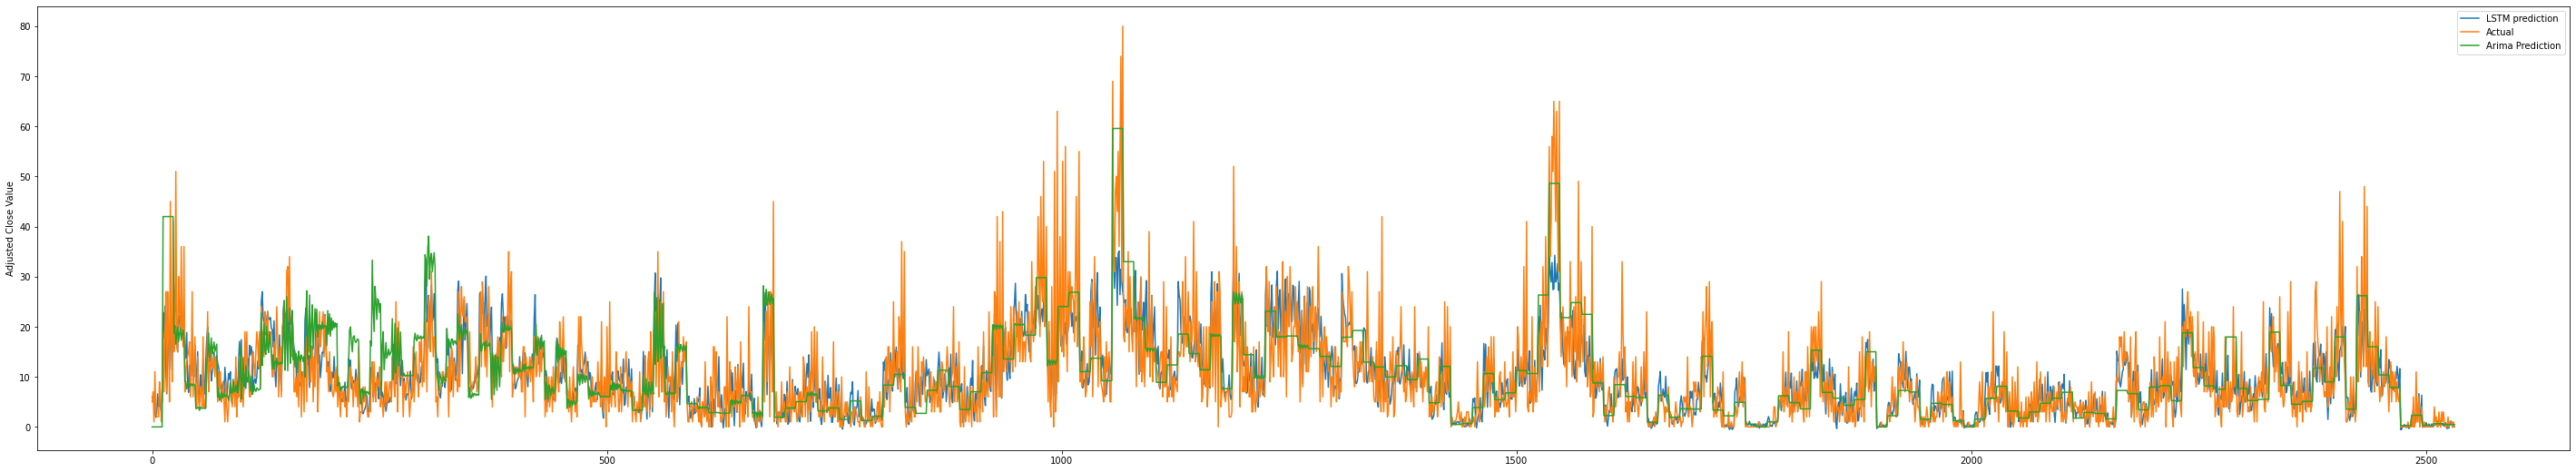

In [ ]:
plt.figure(figsize=(50, 9))
plt.plot(range(len(all_y)), total_predictions, label="LSTM prediction")
plt.plot(range(len(all_y)), all_y, label="Actual")
plt.plot(range(len(all_y)), total_predictions_a, label="Arima Prediction")
plt.ylabel("Adjusted Close Value")
plt.legend()
plt.show()